# Wikipedia Thanks Recipient Analysis Spring 2020 
# [PROVISIONAL- DO NOT SHARE OR CITE UNLESS YOU WANT TO DISTRIBUTE POTENTIALLY-INACCURATE INFORMATION]
[J. Nathan Matias](https://natematias.com), May 2020

Key documents:
* [pre-analysis plan: Receiving Thanks on Wikipedia](https://osf.io/c67rg/)
* [data format description](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit#heading=h.fxaguwxn13cj)

Decisions:
* With only 786 survey compliers, we are way under the sample needed to test our survey questions. So we will only report summary statistics for survey questions.
* Since we aren't testing survey-based hypotheses, we will reduce the number of comparisons that we adjust for.
* In this code, I don't adjust for language and sub-group in the meta-analysis. That's unnecessary because difference_in_means accounts for the randomization strategy. I misunderstood that at the time I pre-registered.

In [47]:
library(plyr)
library(AER)
library(tidyverse)
library(magrittr)
library(gmodels)
library(MASS)
library(estimatr)
library(ri2)
library(ggplot2)
library(ggpubr)   # contains ggarrange
library(png)      # to load logo
library(grid)

### TODO: Add Source Sans as a font for ggplot2
library(sysfonts) # to load source sans pro
# https://rdrr.io/github/kjhealy/sourcesans/src/R/sourcesans.r

## Set visual style
catpalette   <- c("#333333", "#ea5324", "#005073", "#7D868C", "#BDBBBB", "#F2F2F2","#F6F2EB")
chartpalette <- c("#ea5324", "#005073", "#7D868C", "#333333", "#F2F2F2","#BDBBBB", "#F6F2EB")

cat.theme <-  theme_bw() +
              theme(plot.title = element_text(size=13, face="bold", color=catpalette[3]),
                    axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1]),
                    axis.title.y =element_text(size=10, color = catpalette[1]),
                    panel.background = element_rect(fill=catpalette[6]))

# Load Data

In [48]:
data.path = Sys.getenv('TRESORDIR', '~/Tresors')
tresor.path = 'CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thankee/post_experiment_analysis'
fname = 'grat-thankee-all-pre-post-treatment-vars.csv'
f.path = file.path(data.path, tresor.path, fname)
all.participants <- read.csv(f.path)

In [49]:
start.date = "2019-08-02"
end.date   = "2020-02-11"

end.caption.text = "Details at: citizensandtech.org/research/how-do-wikipedians-thank-each-other/


Citizens & Technology Lab - citizensandtech.org
© Creative Commons International Attribution 4.0"

lab.anewc <- "all newcomers"
lab.newc <- "newcomers"
lab.exp <- "experienced"

In [50]:
# cat.logo.filename <- "../../assets/CAT-Logo-Horizontal-social-media-preview-color.png"
# logo.img <- readPNG(cat.logo.filename)
# logo.pngob <- rasterGrob(logo.img)

### Convert columns to column names and formats from the experiment plan

In [51]:
all.participants$two.week.retention  %<>% as.logical
all.participants$complier  %<>% as.logical
all.participants$has.email  %<>% as.logical
all.participants$thanks.not.received.skipped %<>% as.logical
all.participants$thanks.not.received.not.seen  %<>% as.logical
all.participants$thanks.not.received.error  %<>% as.logical
all.participants$thanks.not.received.user.deleted  %<>% as.logical
all.participants$received.multiple.thanks  %<>% as.logical
all.participants$complier.app.any.reason  %<>% as.logical

all.participants$TREAT <- all.participants$randomization.arm
all.participants$block <- all.participants$randomization.block.id
all.participants$prev.experience <- all.participants$prev.experience.assignment
all.participants$newcomer <- all.participants$prev.experience=="bin_0"

all.participants$prev.experience.assignment.days <- 
    as.numeric(str_replace(all.participants$prev.experience, "bin_", ""))

### Remove blocks that include accounts that were deleted

In [52]:
blocks.to.omit.deleted <- subset(all.participants, thanks.not.received.user.deleted)$block

#### Remove Blocks that were Multiply Thanked

In [53]:
length(unique(subset(all.participants,received.multiple.thanks)$block))
blocks.to.omit.multiple.thanks <- unique(subset(all.participants,received.multiple.thanks)$block)

[1] 81

In [54]:
participants <- subset(all.participants, 
                       (block %in% blocks.to.omit.deleted)!=TRUE & 
                       (block %in% blocks.to.omit.multiple.thanks)!=TRUE
                      )

# Baseline Descriptive Information

## Study Participants

In [55]:
# CrossTable(participants$lang, participants$TREAT, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

## Previous Experience by Language


In [56]:
# CrossTable(participants$prev.experience.assignment.days, 
#            participants$lang, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

In [57]:
# CrossTable(participants$lang, 
#            participants$newcomer, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

## Treatment by Previous Experience

In [58]:
# CrossTable(participants$prev.experience.assignment.days, participants$TREAT, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

## Received Thanks by Experience and Language

In [59]:
# CrossTable(subset(participants, TREAT==1)$newcomer, 
#            subset(participants, TREAT==1)$complier.app.any.reason,
#            prop.t=FALSE, prop.chisq=FALSE, prop.c=FALSE)

In [60]:
# CrossTable(paste(subset(participants, TREAT==1)$lang, 
#                  subset(participants, TREAT==1)$newcomer), 
#            subset(participants, TREAT==1)$complier.app.any.reason,
#            prop.t=FALSE, prop.chisq=FALSE, prop.c=FALSE)

## Survey Compliance

### Survey Compliance by Language

In [61]:
sum(participants$complier)/nrow(participants)

[1] 0.05021605

In [62]:
# CrossTable(participants$prev.experience.assignment.days, participants$complier, 
#            prop.c = FALSE, prop.r=TRUE, 
#            prop.t=FALSE, prop.chisq = FALSE)

# Analysis

## Create Study Sub-Samples

In [63]:
newcomers.df <- subset(participants, newcomer==TRUE)
experienced.df <- subset(participants, newcomer==FALSE)
newcomer.compliers.df <- subset(newcomers.df,complier==TRUE)

In [64]:
# CrossTable(newcomers.df$lang, newcomers.df$TREAT, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

In [65]:
# CrossTable(experienced.df$lang, experienced.df$TREAT, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

In [66]:
# CrossTable(newcomers.df$TREAT, newcomers.df$complier, 
#            prop.c = FALSE, prop.r=TRUE, 
#            prop.t=FALSE, prop.chisq = FALSE)

# summary(lm(complier ~ TREAT, data=newcomers.df))

# Per-Language Analysis Method

In [67]:
df.estimates <- function(df, lang="all", subgroup="all"){

    df.compliers <- subset(df, complier)

    thanks.model.formula <- "thanks.sent ~ TREAT"
    if(lang=="all"){
        thanks.model.formula <- paste(thanks.model.formula, " + lang")
    }
    
    if(subgroup=="all"){
        thanks.model.formula <- paste(thanks.model.formula, " + newcomer")
    }
    
        
    thanks.model         <- glm.nb(thanks.model.formula, data=df)
    m.thanks.sent        <- coef(summary(thanks.model))
    m.thanks.sent        <- data.frame(cbind(m.thanks.sent, confint(thanks.model)))
    names(m.thanks.sent)[4] <- "pvalue"
    names(m.thanks.sent)[5] <- "CI.Lower"
    names(m.thanks.sent)[6] <- "CI.Upper"
    m.thanks.sent$DF       <- thanks.model$df.residual
    m.thanks.sent$model    <- "thanks sent"
    m.thanks.sent$t.value  <- NA
    m.thanks.sent$n.size   <- nrow(df)
    m.thanks.sent$n.thanked.count <- nrow(subset(df, complier.app.any.reason))
    
    m.retention            <- data.frame(coef(summary(difference_in_means(two.week.retention ~ TREAT, blocks=block, ci=TRUE, data=df))))
    m.retention$model      <- "retention"
    m.retention$z.value    <- NA
    m.retention$n.size     <- nrow(df)
    m.retention$n.thanked.count <- nrow(subset(df, complier.app.any.reason))
    
    m.labor.hours          <- data.frame(coef(summary(difference_in_means(labor.hours.per.day.diff ~ TREAT, blocks=block, ci=TRUE, data=df))))
    m.labor.hours$model    <- "labor hours"
    m.labor.hours$z.value  <- NA
    m.labor.hours$n.size   <- nrow(df)
    m.labor.hours$n.thanked.count <- nrow(subset(df, complier.app.any.reason))

    m.manip.check          <- data.frame(coef(summary(difference_in_means(remembered.thanks<=3 ~ TREAT, ci=TRUE, data=df.compliers))))
    m.manip.check$model    <- "manipulation check"
    m.manip.check$z.value  <- NA
    m.manip.check$n.size   <- nrow(df.compliers)
    m.manip.check$n.thanked.count <-  nrow(subset(df.compliers, complier.app.any.reason))

    names(m.retention)[4]           <- "pvalue"
    names(m.manip.check)[4]         <- "pvalue"
    names(m.labor.hours)[4]         <- "pvalue"


    m.thanks.sent$estimator        <- "glm.nb"
    m.retention$estimator          <- "difference_in_means"
    m.labor.hours$estimator        <- "difference_in_means"
    m.manip.check$estimator        <- "difference_in_means"

    result.df <- rbind(m.thanks.sent, m.retention, 
                       m.labor.hours, m.manip.check)
    
    result.df <- result.df[str_detect(row.names(result.df), "TREAT"),]
    
    #result.df[row.names(result.df)!="(Intercept)",]
    
    result.df$lang     <- lang
    result.df$subgroup <- subgroup
    
    result.df
}

### Aggregate and Adjust Results for All Participants

In [68]:
all.results <- df.estimates(participants)
all.results <- subset(all.results, model!="labor hours")

all.newcomer.results <- df.estimates(subset(participants, newcomer), subgroup="newcomer")
all.results <- rbind(all.results, subset(all.newcomer.results, model=="labor hours"))

## Adjust for multiple comparisons
# adjustment needs to be done at the level of each
# dataframe, since the tests are different for 
# different subgroups and languages.
# When doing adjustment for multiple comparisons
# we omit the manipulation check, since it's not
# one of the confirmatory tests
all.results[all.results$model!="manipulation check",]$pvalue <- p.adjust(all.results[all.results$model!="manipulation check",]$pvalue, method="holm")

Waiting for profiling to be done...
Waiting for profiling to be done...


In [69]:
all.results[c("model","Estimate", "pvalue", "CI.Lower", "CI.Upper", "n.size", "estimator", "subgroup")]

,model,Estimate,pvalue,CI.Lower,CI.Upper,n.size,estimator,subgroup
TREAT,thanks sent,0.474498984,2.054607e-03,0.1895588964,0.76009838,15274,glm.nb,all
TREAT1,retention,0.021998167,9.329827e-04,0.0100450078,0.03395133,15274,difference_in_means,all
TREAT3,manipulation check,0.292051066,2.074219e-16,0.2238649972,0.36023713,767,difference_in_means,all
TREAT2,labor hours,0.002876707,1.150049e-01,-0.0007008952,0.00645431,9984,difference_in_means,newcomer


# Generate Sub-Group Analyses

In [70]:
ar.newcomer.results <- df.estimates(subset(participants, lang=="ar" & newcomer), lang="ar", subgroup="newcomer")
de.newcomer.results <- df.estimates(subset(participants, lang=="de" & newcomer), lang="de", subgroup="newcomer")
pl.newcomer.results <- df.estimates(subset(participants, lang=="pl" & newcomer), lang="pl", subgroup="newcomer")

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...


In [71]:
fa.experienced.results <- df.estimates(subset(participants, lang=="fa" & newcomer!=TRUE), lang="fa", subgroup="experienced")
fa.experienced.results <- subset(fa.experienced.results,model!="labor hours")

pl.experienced.results <- df.estimates(subset(participants, lang=="pl" & newcomer!=TRUE), lang="pl", subgroup="experienced")
pl.experienced.results <- subset(pl.experienced.results,model!="labor hours")

Waiting for profiling to be done...
Waiting for profiling to be done...


In [72]:
ar.newcomer.results[ar.newcomer.results$model!="manipulation check",]$pvalue <- 
        p.adjust(ar.newcomer.results[ar.newcomer.results$model!="manipulation check",]$pvalue, method="holm")

de.newcomer.results[de.newcomer.results$model!="manipulation check",]$pvalue <- 
        p.adjust(de.newcomer.results[de.newcomer.results$model!="manipulation check",]$pvalue, method="holm")

pl.newcomer.results[pl.newcomer.results$model!="manipulation check",]$pvalue <- 
        p.adjust(pl.newcomer.results[pl.newcomer.results$model!="manipulation check",]$pvalue, method="holm")

fa.experienced.results[fa.experienced.results$model!="manipulation check",]$pvalue <- 
        p.adjust(fa.experienced.results[fa.experienced.results$model!="manipulation check",]$pvalue, method="holm")

pl.experienced.results[pl.experienced.results$model!="manipulation check",]$pvalue <- 
        p.adjust(pl.experienced.results[pl.experienced.results$model!="manipulation check",]$pvalue, method="holm")

In [73]:
all.lang.results <- rbind(ar.newcomer.results, de.newcomer.results,
                          pl.newcomer.results, fa.experienced.results,
                          pl.experienced.results, all.results)

#all.lang.results

### Adjust Sub-Group Analyses for Multiple Comparisons

In [74]:
all.results[all.results$model!="manipulation check",]$pvalue <- p.adjust(all.results[all.results$model!="manipulation check",]$pvalue, method="holm")

# Plot Results

### Plot Effect on Labor Hours

In [75]:
subset(all.lang.results, lang=="all" & model == "labor hours")

,Estimate,Std..Error,z.value,pvalue,CI.Lower,CI.Upper,DF,model,t.value,n.size,n.thanked.count,estimator,lang,subgroup
TREAT23,0.002876707,0.001824898,NA,0.1150049,-0.0007008952,0.00645431,4991,labor hours,1.576366,9984,1572,difference_in_means,all,newcomer


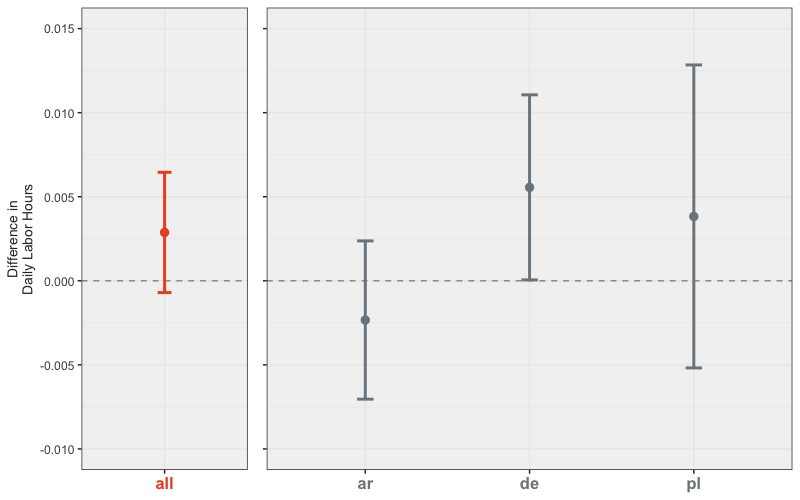

In [101]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

df1 <- subset(all.lang.results, model=="labor hours" & lang == "all" & subgroup=="newcomer")

df2 <- subset(all.lang.results, model=="labor hours" & subgroup=="newcomer" & lang!="all")


labor.hours.participants.count <- prettyNum(df1$n.size, big.mark=",")
labor.hours.participants.count.new.ar <- prettyNum(subset(df2, lang=="ar")$n.size, big.mark=',')
labor.hours.participants.count.new.de <- prettyNum(subset(df2, lang=="de")$n.size, big.mark=',')
labor.hours.participants.count.new.pl <-prettyNum(subset(df2, lang=="pl")$n.size, big.mark=',')
labor.hours.participants.assigned.perc <-round(df1$n.thanked.count/(df1$n.size/2)*100)
labor.hours.participants.assigned.total <-prettyNum(df1$n.size/2, big.mark=",")
labor.hours.participants.assigned.dimest <- prettyNum(df1$pvalue, digits=2)
labor.hours.ylab <- "Difference in\nDaily Labor Hours"


labor.hours.plot.caption <- str_interp("This study did not detect an effect of organized thanks on changes in the amount of time that 
newcomers contribute to Wikipedia on average.")


all.plot <- ggplot(df1, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=df1$CI.Upper, ymin=df1$CI.Lower), 
                      size=1, color=chartpalette[1], width=0.1) +
        geom_point(color=chartpalette[1], size=2.5) +
        ylab(labor.hours.ylab) +
        cat.theme + 
        theme(axis.title.x=element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[1])) +
        ylim(-0.01, 0.015)



lang.plot <- ggplot(df2, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=df2$CI.Upper, ymin=df2$CI.Lower), 
                      size=1, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=2.5) +
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title  = element_blank(), 
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3])) +
        ylab("") +
        xlab("") +
        ylim(-0.01, 0.015)

labor.hours.plot <- ggarrange(all.plot, lang.plot, ncol=2, nrow=1, widths=c(1.5,3.2))

labor.hours.plot + ggsave(file.path('../figs', 'labor.hours.plot.pdf'),
                          width=6, height=2 , units='in', device="pdf")

# labor.hours.plot <- annotate_figure(labor.hours.plot,
#                         bottom=text_grob(labor.hours.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4])) +
#                     ggsave(file.path('../figs', 'labor.hours.plot.png'),
#                           width=6, height=3.375 , units='in')
#labor.hours.plot

### Plot Effect on Two-Week Retention

In [32]:
# subset(all.lang.results, lang=="all" & model == "retention")
# subset(all.newcomer.results, model=="retention")

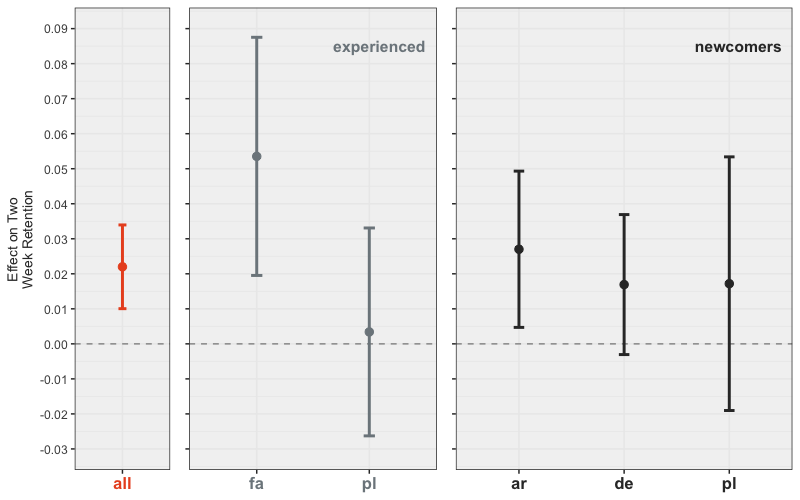

In [102]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

ymax = 0.09
ymin = -0.03

df1 <- subset(all.lang.results, model=="retention" & lang == "all")
df2 <- subset(all.lang.results, model=="retention" & lang!="all" & subgroup == "newcomer")
df3 <- subset(all.newcomer.results, model=="retention")
df4 <- subset(all.lang.results, model=="retention" & lang != "all" & subgroup == "experienced")


retention.plot.est <- prettyNum(df1$Estimate*100, digits=1, format="fg")
retention.plot.count.part <-prettyNum(df1$n.size, big.mark=",")
retention.plot.count.part.new.ar <- prettyNum(subset(df2, lang=="ar")$n.size, big.mark=',')
retention.plot.count.part.new.de <- prettyNum(subset(df2, lang=="de")$n.size, big.mark=',')
retention.plot.count.part.new.pl <- prettyNum(subset(df2, lang=="pl")$n.size, big.mark=',')
retention.plot.count.part.exp.fa <- prettyNum(subset(df4, lang=="fa")$n.size, big.mark=',')
retention.plot.count.part.exp.pl <-prettyNum(subset(df4, lang=="pl")$n.size, big.mark=',')
retention.plot.participants.assigned.perc <-round(df1$n.thanked.count/(df1$n.size/2)*100)
retention.plot.participants.assigned.total <-prettyNum(df1$n.size/2, big.mark=",")
retention.plot.participants.assigned.dimest <- prettyNum(df1$pvalue, digits=2)

retention.plot.ylab <- "Effect on Two\nWeek Retention"
retention.plot.caption <- str_interp(
    "Organized thanking increases two-week retention of Wikipedia contributors by ${retention.plot.est} percentage 
points on average among experienced and newcomer accounts")
 
all.plot <- ggplot(df1, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
            geom_errorbar(aes(ymax=df1$CI.Upper, ymin=df1$CI.Lower), 
                          size=1, color=chartpalette[1], width=0.1) +
            geom_point(color=chartpalette[1], size=2.5) +
            ylab(retention.plot.ylab) +
            scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.01)) +
            cat.theme + 
            theme(axis.title.x=element_blank(),
                  axis.text.x = element_text(size=12, face="bold", color=chartpalette[1]))



lang.plot <- ggplot(df2, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=df2$CI.Upper, ymin=df2$CI.Lower), 
                      size=1, color=chartpalette[4], width=0.1) +
        geom_point(color=chartpalette[4], size=2.5) +
        annotate(geom="text", x=3.5,y=0.085, label=lab.newc, 
                 color=chartpalette[4], fontface=2, size=4, hjust=1) +
        scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.01)) + 
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title  = element_blank(), 
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[4]))



# all.newcomer.plot <- ggplot(df3, aes(lang, Estimate)) +
#         geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
#         geom_errorbar(aes(ymax=df3$CI.Upper, ymin=df3$CI.Lower), 
#                       size=1, color=chartpalette[4], width=0.1) +
#         geom_point(color=chartpalette[4]) +
#         scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.01)) + 
#         scale_x_discrete(labels =c(lab.anewc))  +
#         cat.theme + 
#         theme(axis.text.y = element_blank(),
#               axis.title=element_blank(),
#               axis.text.x = element_text(size=12, face="bold", color=chartpalette[4]))


experienced.plot <- ggplot(df4, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=df4$CI.Upper, ymin=df4$CI.Lower), 
                      size=1, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=2.5) +
        annotate(geom="text", x=2.5,y=0.085, label=lab.exp, 
                 color=chartpalette[3], fontface=2, size=4, hjust=1) +
        scale_y_continuous( limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.01)) + 
        cat.theme + 
        theme(axis.text.y = element_blank(),
              axis.title=element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3]))

retention.plot <- ggarrange(all.plot, experienced.plot, lang.plot, ncol=3, nrow=1, widths=c(2,3, 4))

retention.plot + ggsave(file.path('../figs', 'retention.plot.pdf'),
                          width=6, height=2 , device="pdf", units='in')


# retention.plot <- annotate_figure(retention.plot,
#                         bottom=text_grob(retention.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4]))+
#                     ggsave(file.path('../figs', 'retention.plot.png'),
#                           width=6, height=3.375 , units='in')
#retention.plot

### Plot effect on rate of thanks

In [34]:
# subset(all.lang.results, model=="thanks sent" & lang == "all")

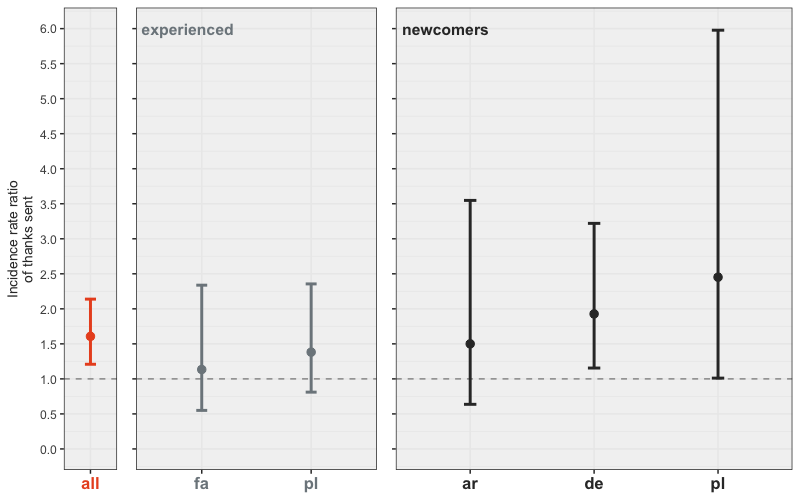

In [103]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

ymax = 6
ymin = 0
scale.by = 0.5

df1 <- subset(all.lang.results, model=="thanks sent" & lang == "all")
df2 <- subset(all.lang.results, model=="thanks sent" & lang!="all" & subgroup == "newcomer")
df3 <- subset(all.lang.results, model=="thanks sent" & lang != "all" & subgroup == "experienced")

thanks.sent.est <- prettyNum(exp(df1$Estimate), digits=2)
thanks.sent.ci.lower <- prettyNum(exp(df1$CI.Lower), digits=2, format="fg")
thanks.sent.ci.upper <- prettyNum(exp(df1$CI.Upper), digits=2, format="fg")
thanks.sent.part <- prettyNum(df1$n.size, big.mark=",")
thanks.sent.new.ar <- prettyNum(subset(df2, lang=="ar")$n.size, big.mark=',')
thanks.sent.new.de <- prettyNum(subset(df2, lang=="de")$n.size, big.mark=',')
thanks.sent.new.pl <- prettyNum(subset(df2, lang=="pl")$n.size, big.mark=',')
thanks.sent.exp.fa <- prettyNum(subset(df3, lang=="fa")$n.size, big.mark=',')
thanks.sent.exp.pl <- prettyNum(subset(df3, lang=="pl")$n.size, big.mark=',')
thanks.sent.assigned.perc <-round(df1$n.thanked.count/(df1$n.size/2)*100)
thanks.sent.assigned.total <-prettyNum(df1$n.size/2, big.mark=",")
thanks.sent.assigned.dimest <- prettyNum(df1$pvalue, digits=2)



thanks.sent.ylab <- "Incidence rate ratio\nof thanks sent"
thanks.sent.plot.caption <- str_interp("Organizing to thank Wikipedia volunteers caused them to thank others and increased the thanks they sent 
by ${thanks.sent.est} times on average")


all.plot <- ggplot(df1, aes(lang, exp(Estimate))) +
        geom_hline(yintercept = 1, linetype="dashed", color="#999999") +
            geom_errorbar(aes(ymax=exp(df1$CI.Upper), ymin=exp(df1$CI.Lower)), 
                          size=1, color=chartpalette[1], width=0.25) +
            geom_point(color=chartpalette[1], size=2.5) +
            ylab(thanks.sent.ylab) +
            scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) +
            cat.theme + 
            theme(axis.title.x=element_blank(),
                  axis.text.x = element_text(size=12, face="bold", color=chartpalette[1]))



newcomer.plot <- ggplot(df2, aes(lang, exp(Estimate))) +
        geom_hline(yintercept = 1, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=exp(df2$CI.Upper), ymin=exp(df2$CI.Lower)), 
                      size=1, color=chartpalette[4], width=0.1) +
        geom_point(color=chartpalette[4], size=2.5) +
        annotate(geom="text", x=0.45,y=6, label=lab.newc, 
                 color=chartpalette[4], fontface=2, size=4, hjust=0) +
        scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) + 
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title  = element_blank(), 
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[4]))



experienced.plot <- ggplot(df3, aes(lang, exp(Estimate))) +
        geom_hline(yintercept = 1, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=exp(df3$CI.Upper), ymin=exp(df3$CI.Lower)), 
                      size=1, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=2.5) +
        annotate(geom="text", x=0.45,y=6, label=lab.exp, 
                 color=chartpalette[3], fontface=2, size=4, hjust=0) +
        scale_y_continuous( limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) + 
        cat.theme + 
        theme(axis.text.y = element_blank(),
              axis.title=element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3]))

thanks.sent.plot <- ggarrange(all.plot,  experienced.plot, newcomer.plot, ncol=3, nrow=1, widths=c(1.2,2.5, 4))

thanks.sent.plot + ggsave(file.path('../figs', 'thanks.sent.plot.pdf'),
                          width=6, height=2, device="pdf", units='in')

# thanks.sent.plot <- annotate_figure(thanks.sent.plot,
#                         bottom=text_grob(thanks.sent.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4]))+
#                     ggsave(file.path('../figs', 'thanks.sent.plot.png'),
#                           width=6, height=4 , units='in')
#thanks.sent.plot

### Checking that people who received thanks actually remembered receiving it, 42 days later

In [36]:
#  plot.effect.facets(subset(all.lang.results, model=="manipulation check"), "Intent to Treat Effect of Receiving Thanks on Remembering that Thanks Was Received")

# Tables of All Results

In [37]:
all.lang.results

,Estimate,Std..Error,z.value,pvalue,CI.Lower,CI.Upper,DF,model,t.value,n.size,n.thanked.count,estimator,lang,subgroup
TREAT,0.405465108,0.435633350,0.9307485,6.621430e-01,-4.513355e-01,1.266331151,3034.00000,thanks sent,NA,3036,189,glm.nb,ar,newcomer
TREAT1,0.027009223,0.011373685,NA,5.305927e-02,4.699410e-03,0.049319036,1517.00000,retention,2.3747117,3036,189,difference_in_means,ar,newcomer
TREAT2,-0.002333275,0.002399823,NA,6.621430e-01,-7.040598e-03,0.002374048,1517.00000,labor hours,-0.9722694,3036,189,difference_in_means,ar,newcomer
TREAT3,0.200000000,0.210818511,NA,3.558411e-01,-2.441866e-01,0.644186588,17.30769,manipulation check,0.9486833,22,11,difference_in_means,ar,newcomer
TREAT4,0.656242624,0.260767478,2.5165815,3.554984e-02,1.438366e-01,1.169359242,5316.00000,thanks sent,NA,5318,1268,glm.nb,de,newcomer
TREAT11,0.016923656,0.010192528,NA,9.695231e-02,-3.062433e-03,0.036909744,2658.00000,retention,1.6603983,5318,1268,difference_in_means,de,newcomer
TREAT21,0.005559013,0.002806535,NA,9.544694e-02,5.580008e-05,0.011062226,2658.00000,labor hours,1.9807391,5318,1268,difference_in_means,de,newcomer
TREAT31,0.369369369,0.077406029,NA,4.445988e-06,2.163661e-01,0.522372655,143.50657,manipulation check,4.7718424,146,74,difference_in_means,de,newcomer
TREAT5,0.896746136,0.449821136,1.9935616,1.386000e-01,1.075717e-02,1.788012090,1628.00000,thanks sent,NA,1630,115,glm.nb,pl,newcomer
TREAT12,0.017177914,0.018447266,NA,7.040625e-01,-1.903190e-02,0.053387732,814.00000,retention,0.9311902,1630,115,difference_in_means,pl,newcomer


# Complier Average Causal Effect
We use two stage least squares regression to estimate the complier average causal effect.

We will report this result in scientific papers after further validating the approach.

In [38]:
## this method generates complier average treatment effect estimates
## for a given subgroup of the study. It assumes that rates of actual
## thanking by volunteers will vary by language and newcomer status

df.cace.estimates <- function(df, lang="all", subgroup="all"){

    
    treat.prob.formula <- "complier.app.any.reason ~ TREAT"
    if(lang=="all"){
        treat.prob.formula <- paste(treat.prob.formula, " + lang")
    }
    
    if(subgroup=="all"){
        treat.prob.formula <- paste(treat.prob.formula, " + newcomer")
    }
    
    treat.prob.m <- lm(treat.prob.formula, data=df)
    
    df$iv <- predict(treat.prob.m, df)

    df.compliers <- subset(df, complier)
    

    thanks.model         <- glm.nb(thanks.sent ~ iv, data=df)
    m.thanks.sent        <- coef(summary(thanks.model))
    m.thanks.sent        <- data.frame(cbind(m.thanks.sent, confint(thanks.model)))
    names(m.thanks.sent)[4] <- "pvalue"
    names(m.thanks.sent)[5] <- "CI.Lower"
    names(m.thanks.sent)[6] <- "CI.Upper"
    m.thanks.sent$DF       <- thanks.model$df.residual
    m.thanks.sent$model    <- "thanks sent"
    m.thanks.sent$t.value  <- NA
    m.thanks.sent$n.size   <- nrow(df)
    m.thanks.sent$n.thanked.count <- nrow(subset(df, complier.app.any.reason))
    
    retention.model        <- lm(two.week.retention ~ iv, data=df)
    m.retention            <- data.frame(coef(summary(retention.model)))
    m.retention            <- cbind(m.retention, confint(retention.model))
    names(m.retention)[4]  <- "pvalue"
    names(m.retention)[5]  <- "CI.Lower"
    names(m.retention)[6]  <- "CI.Upper"
    m.retention$DF         <- retention.model$df
    m.retention$model      <- "retention"
    m.retention$z.value    <- NA
    m.retention$n.size     <- nrow(df)
    m.retention$n.thanked.count <- nrow(subset(df, complier.app.any.reason))
    
    labor.hour.model       <- lm(labor.hours.per.day.diff ~ iv, data=df)
    m.labor.hours          <- data.frame(coef(summary(labor.hour.model)))
    m.labor.hours          <- cbind(m.labor.hours, confint(labor.hour.model))
    names(m.labor.hours)[4] <- "pvalue"
    names(m.labor.hours)[5] <- "CI.Lower"
    names(m.labor.hours)[6] <- "CI.Upper"
    m.labor.hours$DF       <- labor.hour.model$df    
    m.labor.hours$model    <- "labor hours"
    m.labor.hours$z.value  <- NA
    m.labor.hours$n.size   <- nrow(df)
    m.labor.hours$n.thanked.count <- nrow(subset(df, complier.app.any.reason))

    manip.check.model      <- lm(remembered.thanks<=3 ~ iv, data=df.compliers)
    m.manip.check          <- data.frame(coef(summary(manip.check.model)))
    m.manip.check          <- cbind(m.manip.check, confint(manip.check.model))
    names(m.manip.check)[4] <- "pvalue"
    names(m.manip.check)[5] <- "CI.Lower"
    names(m.manip.check)[6] <- "CI.Upper"
    m.manip.check$DF       <- manip.check.model$df    
    m.manip.check$model    <- "manipulation check"
    m.manip.check$z.value  <- NA
    m.manip.check$n.size   <- nrow(df.compliers)
    m.manip.check$n.thanked.count <-  nrow(subset(df.compliers, complier.app.any.reason))

    m.thanks.sent$estimator        <- "glm.nb"
    m.retention$estimator          <- "2sls"
    m.labor.hours$estimator        <- "2sls"
    m.manip.check$estimator        <- "2sls"

    result.df <- rbind(m.retention, m.labor.hours, m.thanks.sent,
                       m.manip.check)
    
    #result.df <- result.df[row.names(result.df)!="(Intercept)",]
    
    result.df$lang     <- lang
    result.df$subgroup <- subgroup
    
    result.df
}

#### Estimate CACE Results

In [39]:
ar.newcomer.cace.results <- df.cace.estimates(subset(participants, lang=="ar" & newcomer), lang="ar", subgroup="newcomer")
de.newcomer.cace.results <- df.cace.estimates(subset(participants, lang=="de" & newcomer), lang="de", subgroup="newcomer")
pl.newcomer.cace.results <- df.cace.estimates(subset(participants, lang=="pl" & newcomer), lang="pl", subgroup="newcomer")

fa.experienced.cace.results <- df.cace.estimates(subset(participants, lang=="fa" & newcomer!=TRUE), lang="fa", subgroup="experienced")
fa.experienced.cace.results <- subset(fa.experienced.cace.results,model!="labor hours")

pl.experienced.cace.results <- df.cace.estimates(subset(participants, lang=="pl" & newcomer!=TRUE), lang="pl", subgroup="experienced")
pl.experienced.cace.results <- subset(pl.experienced.cace.results,model!="labor hours")

all.newcomer.cace.df <- df.cace.estimates(subset(participants, newcomer), subgroup="newcomer")
all.experienced.cace.df <- df.cace.estimates(subset(participants, newcomer!=TRUE), subgroup="experienced")
all.experienced.cace.df <- subset(all.experienced.cace.df,model!="labor hours")

all.cace.df <- df.cace.estimates(participants)

all.cace.models.df <- rbind(
    ar.newcomer.cace.results, 
    de.newcomer.cace.results, 
    pl.newcomer.cace.results,
    fa.experienced.cace.results,
    pl.experienced.cace.results,
    all.newcomer.cace.df,
    all.experienced.cace.df,
    all.cace.df
    )

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...


In [40]:
#all.cace.models.df

In [41]:
# subset(all.cace.models.df, model =="retention" & 
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE)

In [42]:
# plot.effect.facets(subset(all.cace.models.df, model =="retention" & 
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE),
#                    title="Retention CACE")

In [43]:
# subset(all.cace.models.df, model =="labor hours" & 
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE)

In [44]:
# plot.effect.facets(subset(all.cace.models.df, model =="labor hours" & 
#                           subgroup!="all" &
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE),
#                    title="Labour Hours CACE")

In [45]:
# subset(all.cace.models.df, model =="thanks sent" & 
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE)

In [46]:
# plot.effect.facets(subset(all.cace.models.df, model =="thanks sent" & 
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE),
#                    title="Thanks Sent CACE")

# Create a Regression Table

In [95]:
subset(all.cace.df)

,Estimate,Std..Error,t.value,pvalue,CI.Lower,CI.Upper,DF,model,z.value,n.size,n.thanked.count,estimator,lang,subgroup
(Intercept),0.214090899,0.004512942,47.439325,0.000000e+00,0.205244995,0.222936803,15272,retention,NA,15274,2702,2sls,all,all
iv,0.197622356,0.016224987,12.180124,5.701594e-34,0.165819445,0.229425267,15272,retention,NA,15274,2702,2sls,all,all
(Intercept)1,-0.006838512,0.001225481,-5.580268,2.442313e-08,-0.009240601,-0.004436423,15272,labor hours,NA,15274,2702,2sls,all,all
iv1,0.001252543,0.004405865,0.284290,7.761920e-01,-0.007383478,0.009888565,15272,labor hours,NA,15274,2702,2sls,all,all
(Intercept)2,-2.179806931,0.100496370,NA,2.527540e-104,-2.366069994,-1.983230734,15272,thanks sent,-21.690405,15274,2702,glm.nb,all,all
iv2,1.541253787,0.357115721,NA,1.589982e-05,0.896165950,2.190497607,15272,thanks sent,4.315839,15274,2702,glm.nb,all,all
(Intercept)3,0.266345811,0.033405887,7.973020,5.687414e-15,0.200766901,0.331924721,759,manipulation check,NA,767,369,2sls,all,all
iv3,0.687856191,0.091222590,7.540415,1.339146e-13,0.508777635,0.866934747,759,manipulation check,NA,767,369,2sls,all,all


# Save Data for LaTeX file

In [57]:
dfs<-Filter(function(x) is.data.frame(get(x)) , ls())
save(list=dfs, file="paper-data.RData", version = 2) # overleaf uses R 3.4 which requires version 2 of Rdata I believe